# Quantitative experiments with Turbofan Engine Degradation Simulation dataset
This dataset contains information was designed to solve predictive maintenance problems. The dataset is accessible here: 
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

In [79]:
import sys
sys.path.append('C:\\Users\\iamollas\\Desktop\\Altruist New')
model_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D1\\'
weights_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D1\\'

In [80]:
import random
import csv
import warnings
import json
import lime.lime_tabular as lt
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Dropout, LSTM, concatenate, Reshape
import json

import keras
from keras.models import Model
from innvestigate.utils.keras import checks
import innvestigate
import innvestigate.utils as iutils
from altruist import Altruist
from meta_explain import MetaExplain
from utilities.dataset import Dataset
from sklearn.preprocessing import MinMaxScaler, maxabs_scale
import numpy as np
np.seterr(invalid='ignore')
warnings.filterwarnings("ignore")

We will now load our TEDS dataset

In [81]:
teds = Dataset()
x_train, y_train, x_test, y_test, feature_names = teds.load_data_turbofan()

In [82]:
feature_names = ['s_02', 's_03', 's_04', 's_07', 's_08', 's_09', 's_11', 's_12',
                 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [83]:
temp_y_train = [[i] for i in y_train]
temp_y_test = [[i] for i in y_test]
target_scaler = MinMaxScaler()
target_scaler.fit(temp_y_train)
y_train = target_scaler.transform(temp_y_train)
y_test = target_scaler.transform(temp_y_test)

And we will build two neural network models. One linear and one non-linear, and one uneccessary complex model.

In [84]:
import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [85]:
linear_input = Input(shape=(x_train[0].shape))
linear_hidden = Flatten()(linear_input)
linear_output = Dense(1, activation='linear')(linear_hidden)
linear_neural = Model(linear_input, linear_output)
linear_neural.compile(optimizer='adam', loss=[
                      root_mean_squared_error], metrics=['mae', 'mse'])

neural_input = Input(shape=(x_train[0].shape))
hidden_input = Reshape((14, 50))(neural_input)
neural_r = []
for i in range(14):
    temp_hidden = LSTM(units=51, dropout=0.5,
                       return_sequences=True, activation='tanh')(hidden_input)
    temp_hidden = Dropout(0.5)(temp_hidden)
    temp_hidden = LSTM(units=50, dropout=0.5,
                       return_sequences=False, activation='tanh')(temp_hidden)
    neural_r.append(temp_hidden)
neural_hidden = concatenate(neural_r)
neural_hidden = Dropout(0.5)(neural_hidden)
neural_hidden = Dense(500, activation='tanh')(neural_hidden)  # Relu and selu
neural_hidden = Dropout(0.5)(neural_hidden)
neural_output = Dense(1, activation='linear')(neural_hidden)  # Relu and selu
neural = Model(neural_input, neural_output)
neural.compile(optimizer='adam', loss=[
               root_mean_squared_error], metrics=['mae', 'mse'])

complex_neural_input = Input(shape=(x_train[0].shape))
complex_input = Reshape((14, 50))(complex_neural_input)
complex_r = []
for i in range(14):
    complex_hidden = LSTM(
        units=51, dropout=0.5, return_sequences=True, activation='tanh')(complex_input)
    complex_hidden = Dropout(0.5)(complex_hidden)
    complex_hidden = LSTM(
        units=50, dropout=0.5, return_sequences=False, activation='relu')(complex_hidden)
    complex_hidden = Dropout(0.5)(complex_hidden)
    complex_hidden = Dense(units=50, activation='relu')(complex_hidden)
    complex_r.append(complex_hidden)
complex_net = concatenate(complex_r)
complex_net = Dropout(0.5)(complex_net)
complex_net = Dense(500, activation='tanh')(complex_net)
complex_net = concatenate([complex_net, Flatten()(complex_neural_input)])
complex_net = Dropout(0.5)(complex_net)
complex_net = Dense(1000, activation='sigmoid')(complex_net)
complex_net = Dropout(0.5)(complex_net)
complex_output = Dense(1, activation='linear')(complex_net)
complex_neural = Model(complex_neural_input, complex_output)
complex_neural.compile(optimizer='adam', loss=[
                       root_mean_squared_error], metrics=['mae', 'mse'])

models = {'lNN': linear_neural, 'NN': neural, 'cNN': complex_neural}

Let's evaluate our models

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def compute_scores(name, y_test, y_pred):
    temp_y_pred = target_scaler.inverse_transform(y_pred)
    y_pred = np.array([i[0] for i in temp_y_pred])
    print(name)
    print('\t', 'MAE:', mean_absolute_error(temp_y_test, y_pred))
    print('\t', 'MSE:', mean_squared_error(temp_y_test, y_pred))
    print('\t', 'RMSE:', sqrt(mean_squared_error(temp_y_test, y_pred)))
    print('\t', 'R2:', r2_score(temp_y_test, y_pred))

In [87]:
train = False
for name, model in models.items():
    if train:
        check_point = ModelCheckpoint(
            "D1_"+name+".hdf5", monitor="val_loss", verbose=0, save_best_only=True, mode="auto")
        model.fit(x_train, y_train, epochs=500, batch_size=512,
                  validation_split=0.33, verbose=0, callbacks=[check_point])
        model.load_weights("D1_"+name+".hdf5")
    else:
        model.load_weights(model_path+"D1_"+name+".hdf5")
    y_pred = model.predict(x_test)
    compute_scores(name, y_test, y_pred)


lNN
	 MAE: 27.4459676816527
	 MSE: 1367.2966335026808
	 RMSE: 36.97697436922984
	 R2: 0.49828356104652527
NN
	 MAE: 24.772757201740628
	 MSE: 1260.1166593068872
	 RMSE: 35.49812191238978
	 R2: 0.537612228771599
cNN
	 MAE: 22.402879480157456
	 MSE: 1069.820192553104
	 RMSE: 32.70810591509548
	 R2: 0.6074396994942856


We will prepare our predict functions to work well with our python scripts!

In [88]:
def predict_cNN(x):
    prediction = models['cNN'].predict(x)
    return [i[0] for i in prediction]

def predict_NN(x):
    prediction = models['NN'].predict(x)
    return [i[0] for i in prediction]

def predict_lNN(x):
    prediction = models['lNN'].predict(x)
    return [i[0] for i in prediction]

predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}

With the following function we generate Integrated Gradients and LRP explainers for a model

In [89]:
def analyzer_generators(model):
    Xs = iutils.to_list(model.outputs)
    ret = []
    for x in Xs:
        layer, node_index, tensor_index = x._keras_history
        if checks.contains_activation(layer, activation="linear"):
            if isinstance(layer, keras.layers.Activation):
                ret.append(layer.get_input_at(node_index))
            else:
                layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(
                    layer)
                ret.append(layer_wo_act(layer.get_input_at(node_index)))
    modified_model = Model(input=model.input, output=ret)
    modified_model.trainable = False
    modified_model.compile(optimizer='adam', loss=[
                           root_mean_squared_error], metrics=['mae', 'mse'])
    analyzer_IG = innvestigate.create_analyzer(
        'integrated_gradients', modified_model, reference_inputs=16*[0])
    analyzer_LRP = innvestigate.create_analyzer('lrp.z', modified_model)
    return [analyzer_IG, analyzer_LRP]

We initiate these explainers for each of our models

In [90]:
analyzer_NN = analyzer_generators(neural)
analyzer_lNN = analyzer_generators(linear_neural)
analyzer_cNN = analyzer_generators(complex_neural)

In [91]:
x_train_flat = x_train.copy().reshape((len(x_train), 700))
flat_features = [str('F_'+str(i)) for i in range(700)]

We prepare each interpretation technique to have the same format!

In [92]:
def fi_lNN(instance, predict_function):
    return [i[0] for i in models['lNN'].get_weights()[0]]

def fi_IG_NN(instance, predict_function):
    a = analyzer_NN[0].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

def fi_LRP_NN(instance, predict_function):
    a = analyzer_NN[1].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

def fi_IG_lNN(instance, predict_function):
    a = analyzer_lNN[0].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

def fi_LRP_lNN(instance, predict_function):
    a = analyzer_lNN[1].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

def fi_IG_cNN(instance, predict_function):
    a = analyzer_cNN[0].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

def fi_LRP_cNN(instance, predict_function):
    a = analyzer_cNN[1].analyze(np.array([instance]))[0]
    a = a.reshape((700))
    return a.tolist()

explainer = lt.LimeTabularExplainer(training_data=x_train_flat,
                                    feature_names=flat_features,
                                    discretize_continuous=False, mode='regression')

def fi_lime(instance, predict_function):
    def predict(x):
        return np.array([i for i in predict_function(x.reshape((len(x), 50, 14)))])
    b = explainer.explain_instance(instance.reshape((700)), predict, num_samples=1000,
                                   num_features=len(list(flat_features)))[0].local_exp
    b = b[list(b.keys())[0]]
    b.sort()
    return [i[1] for i in list(b)]

def fi_random(instance, predict_function):
    a1 = instance.reshape((700))
    seed = (a1.sum() +
            a1.mean())/10
    random.seed(seed)
    return [random.randrange(-1000, 1000)/1000 for i in range(len(flat_features))]

We compute and save the interpretations for easier reproducibility

In [17]:
from sklearn.preprocessing import MaxAbsScaler
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']

    importance_train = []
    for instance in x_train:
        importance_instance = []
        for fi in fi_techniques:
            importance_instance.append(maxabs_scale(fi(instance, neural_type)))
        importance_train.append(importance_instance)
    importance_train = np.array(importance_train)

    importance_test = []
    for instance in x_test:
        importance_instance = []
        for fi in fi_techniques:
            importance_instance.append(maxabs_scale(fi(instance, neural_type)))
        importance_test.append(importance_instance)
    importance_test = np.array(importance_test)

    importances = {'train': importance_train.tolist(),
                   'test': importance_test.tolist()}
    with open('D1_'+neural_name+'.txt', 'w') as outfile:
        json.dump(importances, outfile)

Our quantitative experiments!

Starting with stability! First, we calculate stability for the techniques

In [93]:
from inxai import *
gm = GlobalFeatureMetric()

In [33]:
stability = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, flat_features)

    model_stability = []
    for idf,fi_name in enumerate(fi_names):
        model_stability.append(gm.stability(pd.DataFrame(x_test.reshape((len(x_test),700))),
                                            importance_test[:,idf,:] ,epsilon=3))
    stability[neural_name] = model_stability
    
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

lNN
Inherent 1.0
IG 0.5472611448448466
LRP 0.5472613508372738
LIME 0.8827196335774936
RAND 0.1226924686983951
NN
IG 0.4335826292356411
LRP 0.2420931505494108
LIME 0.35764355702709877
RAND 0.1226924686983951
cNN
IG 0.44254492157659747
LRP 0.1871609435774639
LIME 0.3720531362075941
RAND 0.1226924686983951


In [36]:
meta_interpretations_test = {}
stability_meta = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['lNN'] = []
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['NN'] = []
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['cNN'] = []
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, flat_features)

    print('Starting evaluation for', neural_name)
    noise = 'normal'
    delta = 0.0001

    my_altruist = Altruist(neural_type, x_train, fi_techniques,
                                   flat_features, level=noise, delta=delta)
    for j in range(len(x_test)):
        my_altruist.fis = len(fi_techniques)
        a = my_altruist.find_untruthful(x_test[j], importance_test[j])
        b = np.array(a[-1])

        temp_meta = []
        temp_meta.append(meta_explain.meta_avg(b))
        temp_meta.append(meta_explain.meta_median(b))
        temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
        meta_interpretations_test[neural_name].append(temp_meta)
    
    model_stability = []
    for idf,meta_name in enumerate(meta_names):
        model_stability.append(gm.stability(pd.DataFrame(x_test.reshape((len(x_test),700))),
        np.array(meta_interpretations_test[neural_name])[:,idf,:] ,epsilon=3))
    stability_meta[neural_name] = model_stability

    for idf, stability_score in enumerate(stability_meta[neural_name]):
        print(meta_names[idf], np.mean(stability_score))

Starting evaluation for lNN
Average 0.4085841105718534
Median 0.5331231712395894
RuleBased 0.5236872470424525
Starting evaluation for NN
Average 0.3408131490683045
Median 0.3394097448598858
RuleBased 0.37873233891676067
Starting evaluation for cNN
Average 0.3217044803567875
Median 0.29577670762027564
RuleBased 0.3909713871399417


In [ ]:
predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    meta_explain = MetaExplain(importance_train, flat_features)

    print('Starting evaluation for', neural_name)
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0, 0.0001, 0.001, 0.01]:
            my_altruist = Altruist(neural_type, x_train, fi_techniques,
                                   flat_features, level=noise, delta=delta)
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(x_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(x_test[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D1_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D1_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

We will evaluate the interpretations on the Sensor level as well. 

In [139]:
from tqdm import tqdm

stability = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_test[:1000]:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_test = np.array(importance_test_temp)

    sensor_names = [str('F_'+str(i)) for i in range(14)]

    #meta_explain = MetaExplain(importance_train, sensor_names)

    model_stability = []
    for idf,fi_name in tqdm(enumerate(fi_names)):
        model_stability.append(gm.stability(pd.DataFrame(x_test[:1000].mean(axis=1)),
                                            importance_test[:,idf,:] ,epsilon=3))
    stability[neural_name] = model_stability
    
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

5it [30:22, 364.42s/it]


lNN
Inherent 1.0
IG 0.7754069242128709
LRP 0.7754069925125184
LIME 0.9768406586793216
RAND 0.6236217689799591


4it [28:52, 433.17s/it]


NN
IG 0.7398262757875596
LRP 0.5604877958811235
LIME 0.8696876084631823
RAND 0.6236217689799591


4it [28:41, 430.35s/it]

cNN
IG 0.796563454172929
LRP 0.6788027322776082
LIME 0.8775863495137214
RAND 0.6236217689799591


In [140]:
meta_interpretations_test = {}
stability_meta = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['lNN'] = []
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['NN'] = []
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['cNN'] = []
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_train_temp = []
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_train:
        importance_train_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    for i in importance_test[:1000]:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_train = np.array(importance_train_temp)
    importance_test = np.array(importance_test_temp)

    print('Starting evaluation for', neural_name)
    noise = 'normal'
    delta = 0.0001
    sensor_names = [str('F_'+str(i)) for i in range(14)]

    meta_explain = MetaExplain(importance_train, sensor_names)

    my_altruist = Altruist(neural_type, x_train, fi_techniques,
                                   sensor_names, level=noise, delta=delta, data_type='per Sensor')
    for j in range(len(x_test[:1000])):
        my_altruist.fis = len(fi_techniques)
        a = my_altruist.find_untruthful(x_test[j], importance_test[j])
        b = np.array(a[-1])

        temp_meta = []
        temp_meta.append(meta_explain.meta_avg(b))
        temp_meta.append(meta_explain.meta_median(b))
        temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
        meta_interpretations_test[neural_name].append(temp_meta)
    
    model_stability = []
    for idf,meta_name in enumerate(meta_names):
        model_stability.append(gm.stability(pd.DataFrame(x_test[:1000].mean(axis=1)),
        np.array(meta_interpretations_test[neural_name])[:,idf,:] ,epsilon=3))
    stability_meta[neural_name] = model_stability

    for idf, stability_score in enumerate(stability_meta[neural_name]):
        print(meta_names[idf], np.mean(stability_score))

Starting evaluation for lNN
Average 0.8730950784328496
Median 0.875125988379947
RuleBased 0.6637796813569781
Starting evaluation for NN
Average 0.7950506213069923
Median 0.8020430809623137
RuleBased 0.723609150373512
Starting evaluation for cNN
Average 0.8441905393598813
Median 0.8272401586232013
RuleBased 0.7946388878535836


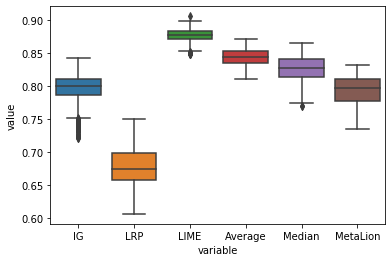

In [141]:
import seaborn as sns
lip_df = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], # 'RAND':stability['cNN'][3], 
                        'Average':stability_meta['cNN'][0], 'Median':stability_meta['cNN'][1], 'MetaLion':stability_meta['cNN'][2]})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [142]:
lip_df_lnn = pd.DataFrame({'IG':stability['lNN'][1], 'LRP':stability['lNN'][2], 'LIME':stability['lNN'][3], 'RAND':stability['lNN'][4]})
lip_df_nn = pd.DataFrame({'IG':stability['NN'][0], 'LRP':stability['NN'][1], 'LIME':stability['NN'][2], 'RAND':stability['NN'][3]})
lip_df_cnn = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], 'RAND':stability['cNN'][3]})

## Measure consistency!

In [148]:
consistency = {}
for idf,fi_name in enumerate(['IG', 'LRP', 'LIME', 'RAND']):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():

        with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
            importances = json.load(json_file)
        importance_test_temp = []
        importance_test = np.array(importances['test'])
        for i in importance_test[:1000]:
            importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
        importance_test = np.array(importance_test_temp)
        if neural_name == 'lNN':
            all_importance_tests.append(np.array(importances['test'])[:1000,1:,:])
        else:
            all_importance_tests.append(np.array(importances['test'][:1000]))
        #meta_explain = MetaExplain(importance_train, feature_names)
    all_importance_tests = np.array(all_importance_tests)
    consistency[fi_name] = gm.consistency(all_importance_tests[:,:,idf,:])
    print(fi_name, np.mean(consistency[fi_name]))

IG 0.11258650447913647
LRP 0.0871944291161526
LIME 0.10901834747484684
RAND 1.0


In [149]:
consistency_meta = {}
for idf, meta_name in enumerate(meta_names):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():
        all_importance_tests.append(np.array(meta_interpretations_test[neural_name]))
    all_importance_tests = np.array(all_importance_tests)
    consistency_meta[meta_name] = gm.consistency(all_importance_tests[:,:,idf,:])
    print(meta_name, np.mean(consistency_meta[meta_name]))

Average 0.7706064399744632
Median 0.6348928652997506
RuleBased 0.6435878756302303


In [150]:
len(consistency['IG'])

1000

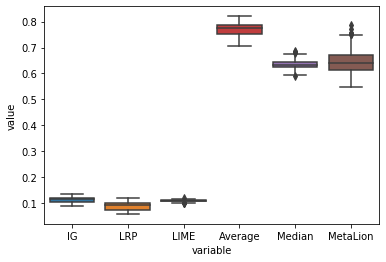

In [151]:
import seaborn as sns
con_df = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], #'RAND':consistency['RAND'], 
                        'Average':consistency_meta['Average'], 'Median':consistency_meta['Median'], 'MetaLion':consistency_meta['RuleBased']})
sns.boxplot(x="variable", y="value", data=pd.melt(con_df))

In [153]:
import seaborn as sns
con_df_models = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], 'RAND':consistency['RAND']})
    

#This is a tough one! Measuring AUPRC for the meta in inXAI technique

In [155]:
from sklearn.compose import ColumnTransformer
pd_x_test = pd.DataFrame(x_test[:1000].reshape((len(x_test[:1000]),700)), columns=flat_features)
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=2),pd_x_test.columns)])
auprc = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])[:1000]
    print(importance_test.shape)
    print('Starting evaluation for', neural_name)
    model_auprc = []
    for idf,fi_name in tqdm(enumerate(fi_names)):
        mean_fi = importance_test[:,idf,:].mean(axis=0)
        model_auprc.append(gm.gradual_perturbation(model=models[neural_name], X=pd_x_test, y=y_test[:1000], column_transformer=ct, importances_orig=mean_fi, 
                                        resolution=50,  count_per_step=10, plot=False, task='r', reshape=(50,14)))
    auprc[neural_name] = model_auprc

(1000, 5, 700)
Starting evaluation for lNN


5it [08:28, 101.64s/it]


(1000, 4, 700)
Starting evaluation for NN


4it [1:20:58, 1214.57s/it]


(1000, 4, 700)
Starting evaluation for cNN


4it [1:31:44, 1376.08s/it]


In [156]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    print(neural_name)
    for idf, auprc_score in enumerate(auprc[neural_name]):
        print(fi_names[idf], np.mean(auprc_score))

lNN
Inherent 198.78001759133895
IG 198.72447586550163
LRP 200.1155860640735
LIME 201.2579751175869
RAND 199.44617678597345
NN
IG 18.61691716734181
LRP 18.68428245110465
LIME 18.717886467914365
RAND 18.677940928682705
cNN
IG 9.180022796778584
LRP 9.277766039359863
LIME 9.22172752775051
RAND 9.282237353272976


In [157]:
from sklearn.metrics import auc

auprc_df_lnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['lNN'][1])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['lNN'][2])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['lNN'][3])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['lNN'][4])]})
auprc_df_nn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['NN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['NN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['NN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['NN'][3])]})
auprc_df_cnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['cNN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['cNN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['cNN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['cNN'][3])]})

In [158]:
cons_alpha = 0.2
lip_alpha=20
auc_alpha=0.1

In [159]:
weights = cons_alpha*con_df_models.iloc[33]+lip_alpha*lip_df_lnn.iloc[33]+auc_alpha/auprc_df_lnn
weights

,IG,LRP,LIME,RAND
0,15.314669,15.313417,19.640208,12.639863


In [161]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_test[:1000]:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_test = np.array(importance_test_temp)

    inxai = []
    for idf, instance in enumerate(x_test[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(importance_test[idf][1:])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        inxai.append(met)
    print('Starting evaluation for', neural_name)
    inxai_stability = gm.stability(pd.DataFrame(x_test[:1000].mean(axis=1)), inxai ,epsilon=3)
    print('inXAI', np.mean(inxai_stability))

Starting evaluation for lNN
inXAI 0.7950475634943016
Starting evaluation for NN
inXAI 0.7607737064929643
Starting evaluation for cNN
inXAI 0.796306129274939


In [163]:
all_importance_tests = []
for neural_name, neural_type in predict_functions.items():
    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
        importance_test_temp = []
        importance_test = np.array(importances['test'])
        for i in importance_test[:1000]:
            importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
        importance_test = np.array(importance_test_temp)
    if neural_name == 'lNN':
        per_neural = np.array(importances['test'])[:1000,1:,:]
    else:
        per_neural = np.array(importances['test'][:1000])
    
    for idf, instance in enumerate(x_test[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(per_neural[idf])/weights.sum().sum()
    all_importance_tests.append(met)
all_importance_tests = np.array(all_importance_tests)
inxai_consistency = gm.consistency(all_importance_tests)
print('inXAI', np.mean(inxai_consistency))

inXAI 0.8922154541544404


## Truthfulness and Commplexity evaluation

In [ ]:
predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_train_temp = []
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_train:
        importance_train_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    for i in importance_test:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_train = np.array(importance_train_temp)
    importance_test = np.array(importance_test_temp)

    sensor_names = [str('F_'+str(i)) for i in range(14)]

    meta_explain = MetaExplain(importance_train, sensor_names)

    print('Starting evaluation for', neural_name)
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0, 0.0001, 0.001, 0.01, 0.1]:
            my_altruist = Altruist(neural_type, x_train, fi_techniques, sensor_names,
                                   level=noise, delta=delta, data_type='per Sensor')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test[:1000])):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(x_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(x_test[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))

            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D1_PS'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D1_PS_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

In [164]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_train_temp = []
    importance_test = np.array(importances['test'][:1000])
    importance_test_temp = []
    for i in importance_train:
        importance_train_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    for i in importance_test:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_train = np.array(importance_train_temp)
    importance_test = np.array(importance_test_temp)

    new_test = []
    for idf, instance in enumerate(x_test[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(importance_test[idf][1:])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot(importance_test[idf])/weights.sum().sum()
        new_test.append([met])
    importance_test = np.array(new_test)

    print('Starting evaluation for', neural_name)
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0 , 0.0001, 0.001, 0.01, 0.1]:
            my_altruist = Altruist(
                neural_type, x_train, fi_techniques, sensor_names, level=noise, delta=delta, data_type='per Sensor')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test[:1000])):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(x_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D1_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D1_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

Starting evaluation for lNN
Starting evaluation for NN
Starting evaluation for cNN


Finally, we will perform the ablation study in per sensor level!

In [ ]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'NN':
        fi_techniques = [fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['LRP', 'LIME', 'RAND']  # ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['LRP', 'LIME', 'RAND']  # ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_train_temp = []
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_train:
        importance_train_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    for i in importance_test:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_train = np.array(importance_train_temp)
    importance_test = np.array(importance_test_temp)
    importance_train = np.delete(importance_train, 2, axis=1)
    importance_test = np.delete(importance_test, 2, axis=1)

    sensor_names = [str('F_'+str(i)) for i in range(14)]

    meta_explain = MetaExplain(importance_train, sensor_names)

    print('Starting evaluation for', neural_name)
    for noise in ['normal']:
        for delta in [0.0001]:
            my_altruist = Altruist(neural_type, x_train, fi_techniques, sensor_names,
                                   level=noise, delta=delta, data_type='per Sensor')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test)):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(x_test[j], importance_test[j])
                for i in range(len(importance_test[j])):

                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(x_test[j], temp_meta)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))

            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D1_PS_AblationIG'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D1_PS_AblationIG_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

In [168]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']

    with open(weights_path+'D1_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    importance_train = np.array(importances['train'])
    importance_test = np.array(importances['test'])
    
    importance_train_temp = []
    importance_test = np.array(importances['test'])
    importance_test_temp = []
    for i in importance_train:
        importance_train_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    for i in importance_test[:1000]:
        importance_test_temp.append(i.reshape((len(i), 50, 14)).mean(axis=1))
    importance_train = np.array(importance_train_temp)
    importance_test = np.array(importance_test_temp)

    fi = 3
    importance_train =np.delete(importance_train, fi, axis=1) #change this manually
    importance_test = np.delete(importance_test, fi, axis=1)
    new_test = []
    for idf, instance in enumerate(x_test[:1000]):
        if neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.drop(weights.columns[[fi]],axis = 1).dot(importance_test[idf])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.drop(weights.columns[[fi]],axis = 1).dot(importance_test[idf])/weights.sum().sum()
        new_test.append([met])
    importance_test = np.array(new_test)

    print('Starting evaluation for', neural_name)
    for noise in ['normal']:
        for delta in [0.0001]:
            my_altruist = Altruist(
                neural_type, x_train, fi_techniques, sensor_names, level=noise, delta=delta, data_type='per Sensor')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(x_test[:1000])):
                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(x_test[j], importance_test[j])
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D1_Ablation_Study_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D1_Ablation_Study_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

Starting evaluation for NN
Starting evaluation for cNN
